# Corrective RAG: Enhancing Retrieval-Augmented Generation



Corrective Retrieval-Augmented Generation (RAG) is a next-level framework that iteratively improves the precision and quality of responses. It blends retrieval-based learning with generative AI, incorporating error-checking loops to deliver accurate, user-satisfying results.

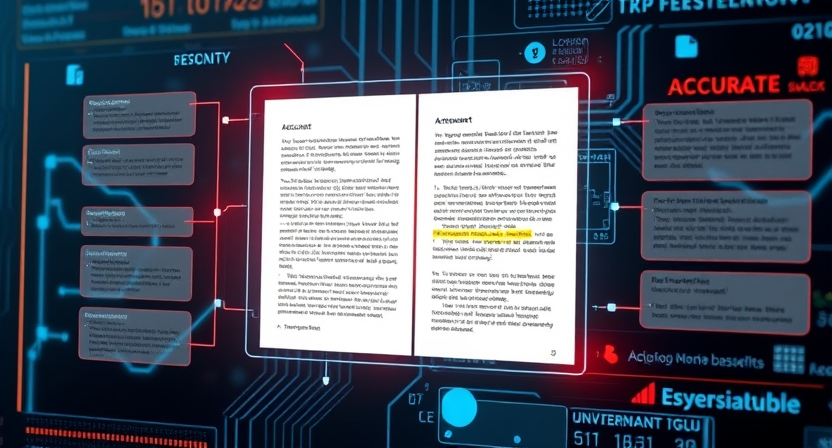

# Understanding Corrective RAG






Corrective RAG goes beyond simple document retrieval by adding an evaluation and correction layer. It evaluates retrieved content for relevance and corrects inaccuracies before generating the final response.



## Key Features
- **Knowledge Refinement**: Decomposes documents into smaller parts, evaluates accuracy, and filters ambiguous or incorrect information.
- **Knowledge Searching**: For ambiguous or incorrect results, Corrective RAG rewrites queries and uses external resources to retrieve better information.
- **Evaluation and Generation**: Combines correct knowledge with refined input to generate precise responses.


## How It Works



Corrective RAG operates in the following steps:

1. **Input Query**: A user submits a query.
2. **Document Retrieval**: Relevant documents are fetched.
3. **Knowledge Correction**:
   - **Correct**: Retain and use accurate documents.
   - **Ambiguous**: Request more specific information.
   - **Incorrect**: Rewrite query and retrieve better results.
4. **Final Response Generation**: Combines validated knowledge to generate the response.

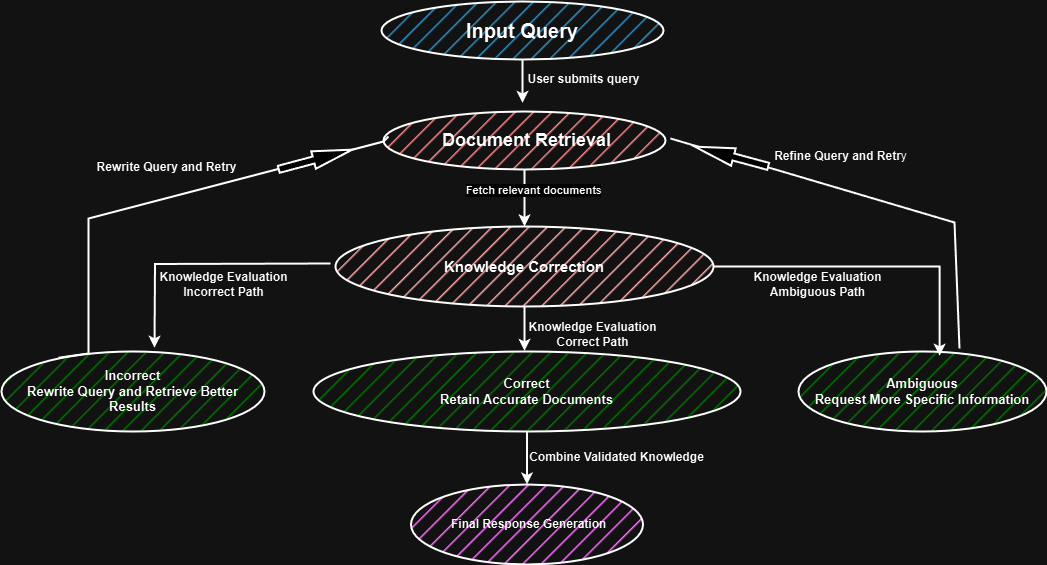

## Let’s build a Corrective RAG-inspired system.



In [1]:
!pip install pypdf2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.8 MB/s eta 0:00:00


In [2]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 2.9 MB/s eta 0:00:00


In [3]:
import os
import requests
from PyPDF2 import PdfReader
from groq import Groq
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# Step 0: Set up the Groq client
client = Groq(api_key="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")

In [5]:
# Step 1: Download and Read the PDF
pdf_url = "https://arxiv.org/pdf/1810.04805.pdf"  # Example: BERT paper
pdf_path = "BERT_paper.pdf"

In [6]:
response = requests.get(pdf_url)
with open(pdf_path, 'wb') as pdf_file:
    pdf_file.write(response.content)

In [7]:
reader = PdfReader(pdf_path)
text = ""
for page in reader.pages:
    text += page.extract_text()

In [8]:
# Step 2: Preprocess Text into Chunks
chunk_size = 150
chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
print(f"Number of chunks created: {len(chunks)}")

Number of chunks created: 427


In [9]:
# Step 3: Convert Chunks into Embeddings (Simulating using TF-IDF)
vectorizer = TfidfVectorizer()
chunk_embeddings = vectorizer.fit_transform(chunks)

In [10]:
# Step 4: Retrieve Relevant Chunks for Query
query = "what is bert?"
query_embedding = vectorizer.transform([query])
similarities = cosine_similarity(query_embedding, chunk_embeddings).flatten()
top_k = 3  # Retrieve top 3 most relevant chunks
top_chunk_indices = similarities.argsort()[-top_k:][::-1]
retrieved_chunks = [chunks[i] for i in top_chunk_indices]

In [11]:
# Step 5: Corrective Validation of Retrieved Chunks
validated_chunks = []
for i, chunk in enumerate(retrieved_chunks):
    try:
        validation_response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a fact-checking assistant."},
                {"role": "user", "content": f"Validate this document for relevance and accuracy:\n\n{chunk}\n\nDoes it correctly address the query '{query}'?"},
            ],
            model="llama3-8b-8192",
        )
        feedback = validation_response.choices[0].message.content
        print(f"\nChunk {i+1} Validation Feedback: {feedback}\n")

        if "accurate" in feedback.lower():
            validated_chunks.append(chunk)
        elif "ambiguous" in feedback.lower():
            print(f"Chunk {i+1} marked as ambiguous. Requesting more specific information.")
        else:
            print(f"Chunk {i+1} deemed incorrect. Ignored.")
    except Exception as e:
        print(f"Error during chunk validation: {e}")


Chunk 1 Validation Feedback: This document appears to be a brief extract or a snippet from a larger document, but it does not accurately address the query "what is BERT?" because it only mentions BERT in a comparative context with GPT, without providing any basic information about what BERT is or what it does.

BERT (short for Bidirectional Encoder Representations from Transformers) is a pre-trained language model developed by Google that is designed to understand natural language processing tasks, including question-answering, language translation, and more. It is not explicitly defined or described in this document.

Therefore, I would rate the relevance of this document to the query "what is BERT?" as low. The document only mentions BERT in passing, without providing any meaningful information about its purpose, functionality, or capabilities.


Chunk 2 Validation Feedback: This document appears to be a table comparing the performance of different BERT models on various tasks. It d

In [12]:
# Step 6: Generate Final Response Using Validated Knowledge
if validated_chunks:
    context = "\n\n".join(validated_chunks)
    try:
        final_response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": f"Based on the validated context: \n\n{context}\n\nAnswer the query: {query}"},
            ],
            model="llama3-8b-8192",
        )
        print("\n--- Final Response ---\n")
        print(final_response.choices[0].message.content)
    except Exception as e:
        print(f"Error during final response generation: {e}")
else:
    print("No valid chunks found. Unable to generate a response.")


--- Final Response ---

BERT stands for Bidirectional Encoder Representations from Transformers. It is a language model developed by Google that is trained on a large corpus of text to understand and generate human-like language.


## Explanation

### Import Libraries
- Libraries are imported for file handling, downloading, PDF reading, text processing, and AI communication.

### Set Up Groq Client
- The Groq client is initialized with an API key for API interaction.

### Download and Read PDF
- The PDF is downloaded using its URL and saved locally.
- `PdfReader` extracts the text content from the downloaded PDF.

### Preprocess Text into Chunks
- The extracted text is divided into smaller chunks of 1000 characters to facilitate analysis and processing.

### Convert Chunks into Embeddings
- TF-IDF is used to transform text chunks into vector embeddings for similarity calculations.

### Retrieve Relevant Chunks for Query
- Cosine similarity is computed between the query and each chunk's embeddings.
- The top three most relevant chunks are selected based on similarity scores.

### Corrective Validation of Retrieved Chunks
- Each retrieved chunk is sent to the Groq client for relevance and accuracy validation.
- Feedback from the validation model determines if a chunk is "accurate," "ambiguous," or "incorrect."
- Only validated chunks marked as accurate are retained for further processing.

### Generate Final Response Using Validated Knowledge
- The validated chunks are merged into a single context.
- The context and query are passed to the Groq model to generate a comprehensive response.
- If no valid chunks are found, a message indicating the inability to generate a response is displayed.

### Handle Errors
- Error handling is implemented to capture and report issues during validation or response generation.


## Applications



- **Customer Support**: Enhance chatbot accuracy by refining ambiguous queries.
- **Education**: Help students retrieve precise answers to complex queries.
- **Healthcare**: Provide reliable patient summaries by filtering irrelevant information.
- **Legal Research**: Identify key case facts while avoiding ambiguity.

## Limitations



- **Computation Overhead**: Repeated query refinements can increase latency.
- **Ambiguity Handling**: Some ambiguous information might remain unresolved.
- **Scalability**: Processing large datasets in real-time can be resource-intensive.

## Extensions and Applications



- **Education**: Build intelligent systems that refine answers for student queries.
- **Customer Support**: Automate issue resolution with high accuracy.
- **Research Assistance**: Validate and enhance responses in academic fields.


We have implemented Corrective RAG, and now, we will transition to Speculative RAG. This approach uses a small, specialized model for drafting and a larger, generalist model for verification, ensuring efficiency and accuracy. By enabling parallel drafting and offloading complex tasks, it speeds up responses and reduces computational load, outperforming traditional RAG systems.
